In [1]:
from IPython.display import clear_output
!pip install imutils
!pip install -q efficientnet
!pip install numpy==1.21.6
clear_output()

In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import tensorflow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, Callback


init_notebook_mode(connected=True)
RANDOM_SEED = 333
clear_output()

In [3]:
!apt-get install tree
clear_output()
!mkdir TRAIN TEST VAL TEST_BMI TEST_BDB TEST_BMD TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO TEST_BMI/YES TEST_BMI/NO TEST_BDB/YES TEST_BDB/NO TEST_BMD/YES TEST_BMD/NO
!tree -d

.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TEST_BDB
│   ├── NO
│   └── YES
├── TEST_BMD
│   ├── NO
│   └── YES
├── TEST_BMI
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

19 directories


In [4]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets list

Mounted at /content/drive


Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Sep 21 17:29 kaggle.json
/content
401 - Unauthorized - Unauthenticated


In [5]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection
!unzip brain-tumor-detection.zip

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
 89% 75.0M/84.0M [00:00<00:00, 178MB/s]
100% 84.0M/84.0M [00:00<00:00, 150MB/s]
Archive:  brain-tumor-detection.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jp

In [6]:
!kaggle datasets download -d dorianea/bd-braintumor
!unzip bd-braintumor.zip

Streaming output truncated to the last 5000 lines.
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 4.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 5.jpeg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 6.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 7.jpeg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 8.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 89.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 9.png  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 90.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 91.jpeg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 92.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 923.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 94.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 95.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 96.jpg  
  inflating: Tumeur_cerveau/train/2/netinvcontmirinvno 

In [7]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 60% 9.00M/15.1M [00:00<00:00, 57.3MB/s]
100% 15.1M/15.1M [00:00<00:00, 84.6MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: b

In [9]:
CLASS_list = ['no','yes']
IMG_PATH = '/content/brain_tumor_detection'
print(os.listdir(IMG_PATH))
print(CLASS_list)

['Br35H-Mask-RCNN', 'yes', 'pred', 'no']
['no', 'yes']


In [ ]:
#rmdir '/content/brain_tumor_detection/no/.ipynb_checkpoints'

In [10]:
IMG_PATH = '/content/brain_tumor_detection'

for CLASS in CLASS_list:
    if (not CLASS.startswith('.') and (not CLASS.startswith('pred'))):
        print(IMG_PATH + '     ' + CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + '/' + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/' + CLASS)):
            img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME
            if n < 200:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 1200:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

/content/brain_tumor_detection     no
1591
/content/brain_tumor_detection     yes
1655


In [11]:
IMG_PATH = '/content/brain_tumor_dataset'
for CLASS in CLASS_list:
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + '/' + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/' + CLASS)):
            img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME
            if n < 500:
                shutil.copy(img, 'TEST_BMI/' + CLASS.upper() + '/' + FILE_NAME)

In [12]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
TEST_BMI_DIR = 'TEST_BMI/'
TEST_BMD_DIR = 'TEST_BMD/'
TEST_BDB_DIR = 'TEST_BDB/'
IMG_SIZE = (224,224)
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)
X_test_bmi, y_test_bmi, _ = load_data(TEST_BMI_DIR, IMG_SIZE)
X_test_bmd, y_test_bmd, _ = load_data(TEST_BMD_DIR, IMG_SIZE)
X_test_bdb, y_test_bdb, _ = load_data(TEST_BDB_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


846 images loaded from VAL/ directory.


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


253 images loaded from TEST_BMI/ directory.


100%|██████████| 2/2 [00:00<00:00, 3899.86it/s]


0 images loaded from TEST_BMD/ directory.


100%|██████████| 2/2 [00:00<00:00, 3499.63it/s]

0 images loaded from TEST_BDB/ directory.


In [14]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test, y_test_bmi, y_test_bmd, y_test_bdb):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set', 'Test_BMI Set', 'Test_BMD Set', 'Test_BDB Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set', 'Test_BMI Set', 'Test_BMD Set', 'Test_BDB Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [15]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [16]:
plot_samples(X_test_bdb, y_test_bdb, labels, 10)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

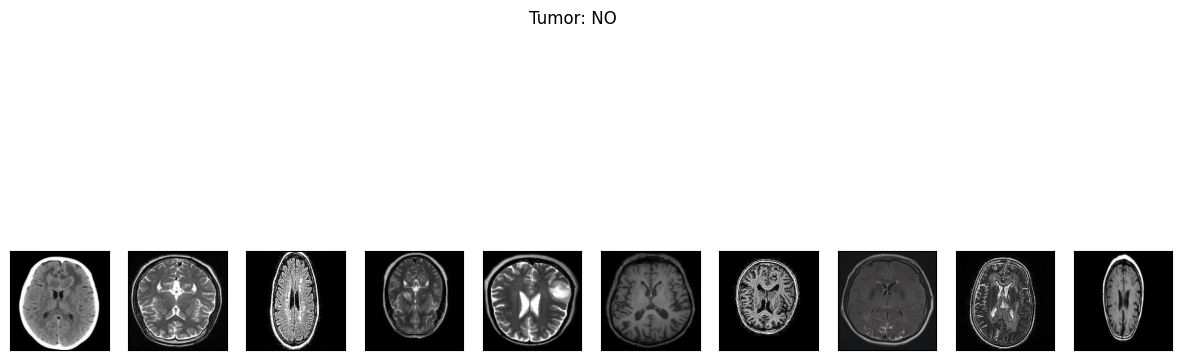

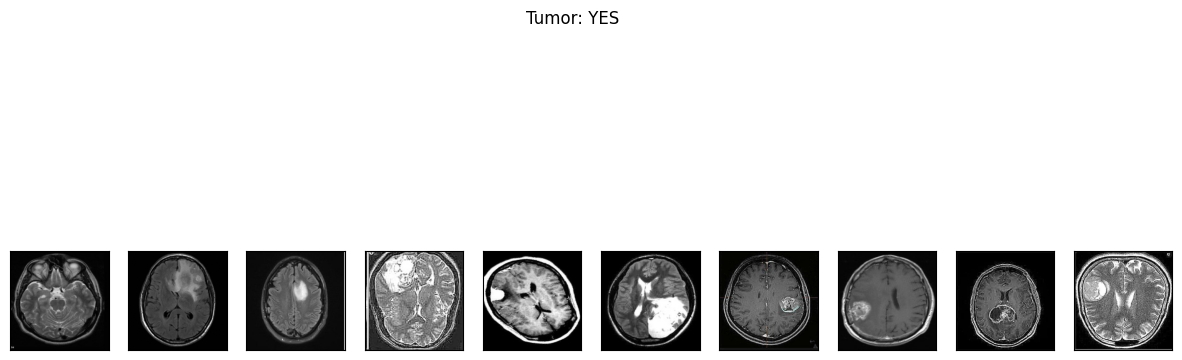

In [17]:
plot_samples(X_train, y_train, labels, 10)

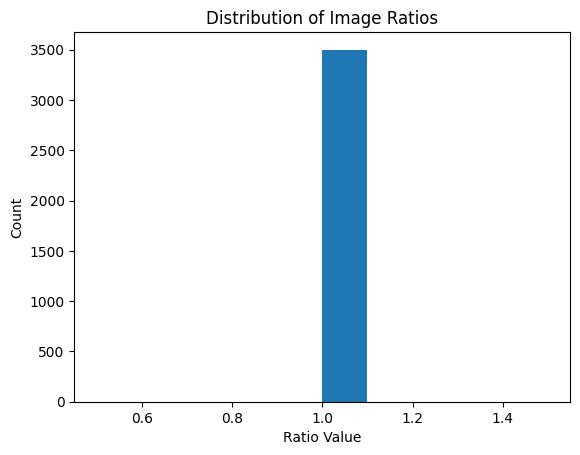

In [18]:
RATIO_LIST = []
for set in (X_train, X_test, X_val, X_test_bmi, X_test_bdb, X_test_bmd):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [19]:
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.

    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H

       .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

 #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')

        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)

<>:61: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:75: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:61: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:75: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<ipython-input-19-4087342cd823>:61: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<ipython-input-19-4087342cd823>:75: SyntaxWarning:

"is not" with a literal. Did you mean "!="?



In [20]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
kernel_2 = np.array([[-1, -1, -1],
                    [-1, 9,-1],
                    [-1, -1, -1]])

kernel_3 = np.array([[1, 1, 1],
                    [1, -7, 1],
                    [1, 1, 1]])

kernel_4 = np.array([[-1, -1, -1, -1, -1],
                    [-1, 2, 2, 2, -1],
                    [-1, 2, 8, 2, -1],
                    [-1, 2, 2, 2, -1],
                    [-1, -1, -1, -1, -1]]) / 8.0

In [21]:
def preprocessing_imgs(set_name, add_pixels_value=0, target_size = (224, 224)):
    """
    Finds the extreme points on the image and crops the rectangular out of them

    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY) #-transfer to grayscale
        #homo_filter = HomomorphicFilter(a = 0.9, b = 1.4)
        #new_img = homo_filter.filter(I=new_img, filter_params=[30,2])
        #new_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
        new_img = cv2.equalizeHist(new_img) #-equalizing the intensity histogram
        new_img = cv2.cvtColor(new_img,cv2.COLOR_GRAY2RGB)
        new_img = cv2.resize(new_img, target_size)
        set_new.append(new_img)

    return np.array(set_new)

In [22]:
X_train_crop = preprocessing_imgs(set_name=X_train)
X_val_crop = preprocessing_imgs(set_name=X_val)
X_test_crop = preprocessing_imgs(set_name=X_test)
X_test_bmi_crop = preprocessing_imgs(set_name=X_test_bmi)
X_test_bmd_crop = preprocessing_imgs(set_name=X_test_bmd)
X_test_bdb_crop = preprocessing_imgs(set_name=X_test_bdb )

In [23]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [24]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TEST_BMI_CROP TEST_BDB_CROP TEST_BMD_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO TEST_BMI_CROP/YES TEST_BMI_CROP/NO TEST_BDB_CROP/YES TEST_BDB_CROP/NO TEST_BMD_CROP/YES TEST_BMD_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')
save_new_images(X_test_bmi_crop, y_test_bmi, folder_name='TEST_BMI_CROP/')
save_new_images(X_test_bmd_crop, y_test_bmd, folder_name='TEST_BMD_CROP/')
save_new_images(X_test_bdb_crop, y_test_bdb, folder_name='TEST_BDB_CROP/' )

In [25]:
def resize_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [26]:
X_train_crop_prep = resize_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_crop_prep = resize_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_crop_prep = resize_imgs(set_name=X_val_crop, img_size=IMG_SIZE)
X_test_bmi_crop_prep = resize_imgs(set_name=X_test_bmi_crop, img_size=IMG_SIZE)
X_test_bdb_crop_prep = resize_imgs(set_name=X_test_bdb_crop, img_size=IMG_SIZE)
X_test_bmd_crop_prep = resize_imgs(set_name=X_test_bmd_crop, img_size=IMG_SIZE)

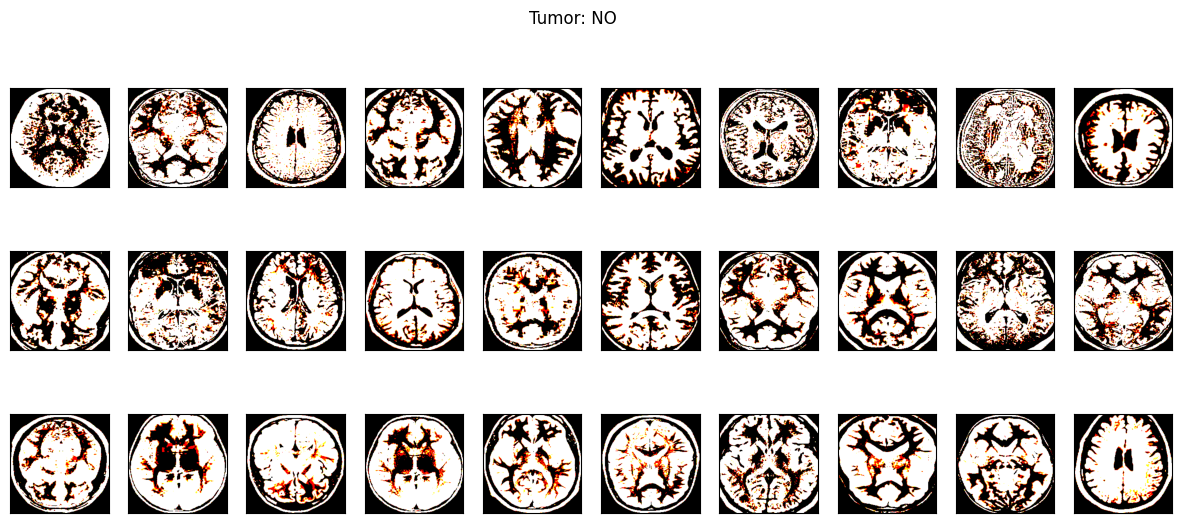

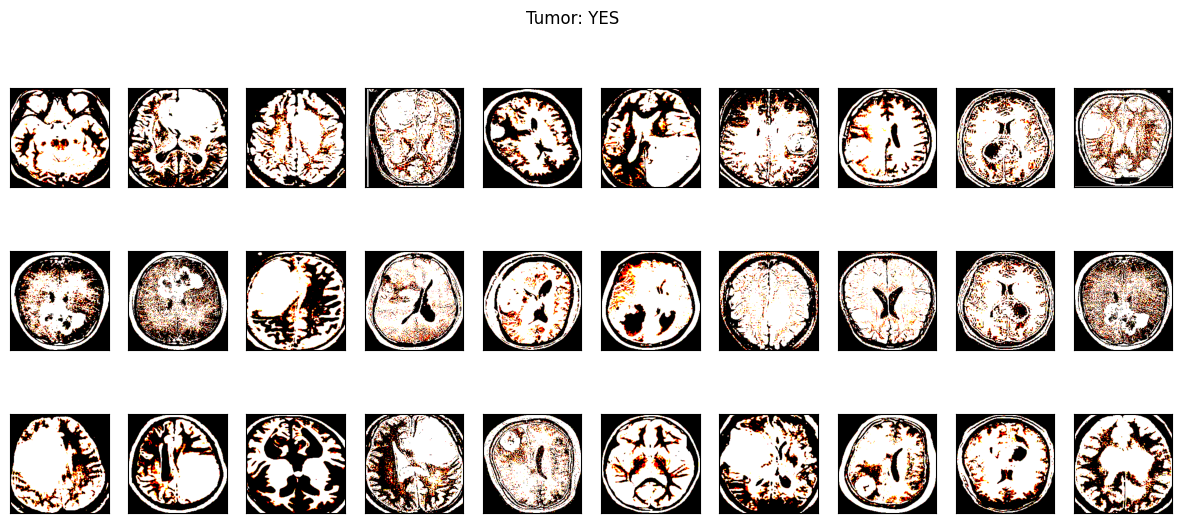

In [27]:
plot_samples(X_train_crop_prep, y_train, labels, 30)

In [28]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=False,
    vertical_flip=False
  )

In [29]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

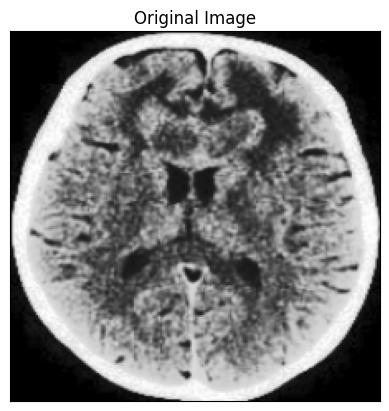

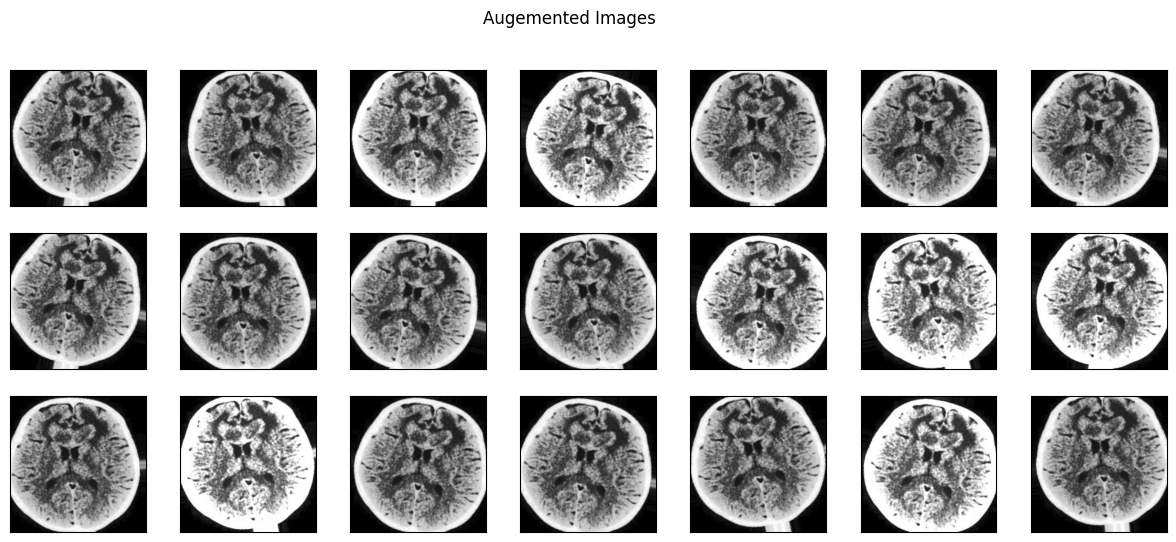

In [30]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [31]:
!rm -rf preview/

In [32]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2000 images belonging to 2 classes.
Found 846 images belonging to 2 classes.


In [33]:
from tensorflow.keras import layers as L

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("EfficientNetB2_cropping+equalization.keras", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [35]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define the input tensor
input_tensor = Input(shape=(224, 224, 3))

NUM_CLASSES = 1

# Instantiate the EfficientNetB2 model as base_model
base_model = EfficientNetB2(weights='imagenet', # Load weights pre-trained on ImageNet
                            include_top=False,  # Do not include the ImageNet classifier at the top
                            input_tensor=input_tensor)

# Apply base model
x = base_model(input_tensor)
print(f"Shape after EfficientNetB2: {x.shape}")  # Debug shape after EfficientNetB2

# Add pooling and dropout
x = GlobalMaxPooling2D()(x)
print(f"Shape after GlobalMaxPooling2D: {x.shape}")  # Debug shape after GlobalMaxPooling2D

x = Dropout(rate=0.2)(x)
print(f"Shape after Dropout: {x.shape}")  # Debug shape after Dropout

# Add dense output layer
output_tensor = Dense(NUM_CLASSES, activation='sigmoid')(x)
print(f"Shape after Dense: {x.shape}")  # Debug shape after Dense

efficientnet = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
efficientnet.summary()

31790344/31790344 [==============================] - 0s 0us/step
Shape after EfficientNetB2: (None, 7, 7, 1408)
Shape after GlobalMaxPooling2D: (None, 1408)
Shape after Dropout: (None, 1408)
Shape after Dense: (None, 1408)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 global_max_pooling2d (Glob  (None, 1408)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                    

In [ ]:
import efficientnet.tfkeras as efn
NUM_CLASSES = 1

efficientnet = tf.keras.Sequential([
    efn.EfficientNetB2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
    ])

efficientnet.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

efficientnet.summary()

31936256/31936256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ValueError: Undefined shapes are not supported.

In [36]:
import time

start = time.time()

efficientnet_history = efficientnet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
    callbacks=[es,tensorboard, checkpoint, reduce_lr]
    )

end = time.time()
print(end - start)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8920


Epoch 1: val_accuracy improved from -inf to 0.94792, saving model to EfficientNetB2_cropping+equalization.keras
63/63 [==============================] - 147s 2s/step - loss: 0.4746 - accuracy: 0.8920 - val_loss: 0.1801 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9655


Epoch 2: val_accuracy improved from 0.94792 to 0.95625, saving model to EfficientNetB2_cropping+equalization.keras
63/63 [==============================] - 110s 2s/step - loss: 0.1210 - accuracy: 0.9655 - val_loss: 0.1154 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9855


Epoch 3: val_accuracy improved from 0.95625 to 0.98958, saving model to EfficientNetB2_cropping+equalization.keras
63/63 [==============================] - 108s 2s/step - loss: 0.0553 - accuracy: 0.9855 - val_loss: 0.0271 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9840


Epoch 4: val_accuracy improved from 0.98958 to 0.99792, saving model to EfficientNetB2_cropping+equalization.keras
63/63 [==============================] - 107s 2s/step - loss: 0.0582 - accuracy: 0.9840 - val_loss: 0.0078 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9810


Epoch 5: val_accuracy did not improve from 0.99792
63/63 [==============================] - 104s 2s/step - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.0169 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9965


Epoch 6: val_accuracy did not improve from 0.99792

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
63/63 [==============================] - 104s 2s/step - loss: 0.0145 - accuracy: 0.9965 - val_loss: 0.0063 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9950


Epoch 7: val_accuracy did not improve from 0.99792
63/63 [==============================] - 102s 2s/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.0095 - val_accuracy: 0.9958 - lr: 3.0000e-04
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9985


Epoch 8: val_accuracy did not improve from 0.99792

Epoch 8: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
63/63 [==============================] - 103s 2s/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0104 - val_accuracy: 0.9937 - lr: 3.0000e-04
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990


Epoch 9: val_accuracy improved from 0.99792 to 1.00000, saving model to EfficientNetB2_cropping+equalization.keras
63/63 [==============================] - 104s 2s/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0018 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995


Epoch 10: val_accuracy did not improve from 1.00000
63/63 [==============================] - 102s 2s/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0074 - val_accuracy: 0.9958 - lr: 9.0000e-05
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000


Epoch 11: val_accuracy did not improve from 1.00000

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
63/63 [==============================] - 102s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9937 - lr: 9.0000e-05
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9995


Epoch 12: val_accuracy did not improve from 1.00000
63/63 [==============================] - 104s 2s/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0055 - val_accuracy: 0.9979 - lr: 2.7000e-05
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9975


Epoch 13: val_accuracy did not improve from 1.00000

Epoch 13: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
63/63 [==============================] - 104s 2s/step - loss: 0.0061 - accuracy: 0.9975 - val_loss: 0.0100 - val_accuracy: 0.9937 - lr: 2.7000e-05
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000


Epoch 14: val_accuracy did not improve from 1.00000
63/63 [==============================] - 102s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9937 - lr: 8.1000e-06
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9995


Epoch 15: val_accuracy did not improve from 1.00000

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
63/63 [==============================] - 102s 2s/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0075 - val_accuracy: 0.9958 - lr: 8.1000e-06
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000


Epoch 16: val_accuracy did not improve from 1.00000
63/63 [==============================] - 101s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9958 - lr: 2.4300e-06
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9995


Epoch 17: val_accuracy did not improve from 1.00000

Epoch 17: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
63/63 [==============================] - 102s 2s/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.0078 - val_accuracy: 0.9958 - lr: 2.4300e-06
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990


Epoch 18: val_accuracy did not improve from 1.00000
63/63 [==============================] - 102s 2s/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0039 - val_accuracy: 0.9958 - lr: 7.2900e-07
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980


Epoch 19: val_accuracy did not improve from 1.00000

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
63/63 [==============================] - 102s 2s/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0046 - val_accuracy: 0.9958 - lr: 7.2900e-07
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995


Epoch 20: val_accuracy did not improve from 1.00000
63/63 [==============================] - 103s 2s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0104 - val_accuracy: 0.9937 - lr: 2.1870e-07
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000


Epoch 21: val_accuracy did not improve from 1.00000

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
63/63 [==============================] - 103s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9917 - lr: 2.1870e-07
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000


Epoch 22: val_accuracy did not improve from 1.00000
63/63 [==============================] - 104s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9979 - lr: 6.5610e-08
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9985


Epoch 23: val_accuracy did not improve from 1.00000

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.9683000829218145e-08.
63/63 [==============================] - 103s 2s/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0121 - val_accuracy: 0.9917 - lr: 6.5610e-08
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995


Epoch 24: val_accuracy did not improve from 1.00000
63/63 [==============================] - 103s 2s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0074 - val_accuracy: 0.9958 - lr: 1.9683e-08
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000


Epoch 25: val_accuracy did not improve from 1.00000

Epoch 25: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
63/63 [==============================] - 104s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9958 - lr: 1.9683e-08
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9985


Epoch 26: val_accuracy did not improve from 1.00000
63/63 [==============================] - 102s 2s/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0042 - val_accuracy: 0.9958 - lr: 5.9049e-09
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9980


Epoch 27: val_accuracy did not improve from 1.00000

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.7714700373261393e-09.
63/63 [==============================] - 102s 2s/step - loss: 0.0027 - accuracy: 0.9980 - val_loss: 0.0021 - val_accuracy: 0.9979 - lr: 5.9049e-09
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000


Epoch 28: val_accuracy did not improve from 1.00000
63/63 [==============================] - 103s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9937 - lr: 1.7715e-09
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000


Epoch 29: val_accuracy did not improve from 1.00000

Epoch 29: ReduceLROnPlateau reducing learning rate to 5.314410245205181e-10.
63/63 [==============================] - 102s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9958 - lr: 1.7715e-09
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000


Epoch 30: val_accuracy did not improve from 1.00000
63/63 [==============================] - 103s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.8107e-04 - val_accuracy: 1.0000 - lr: 5.3144e-10
3144.7204978466034


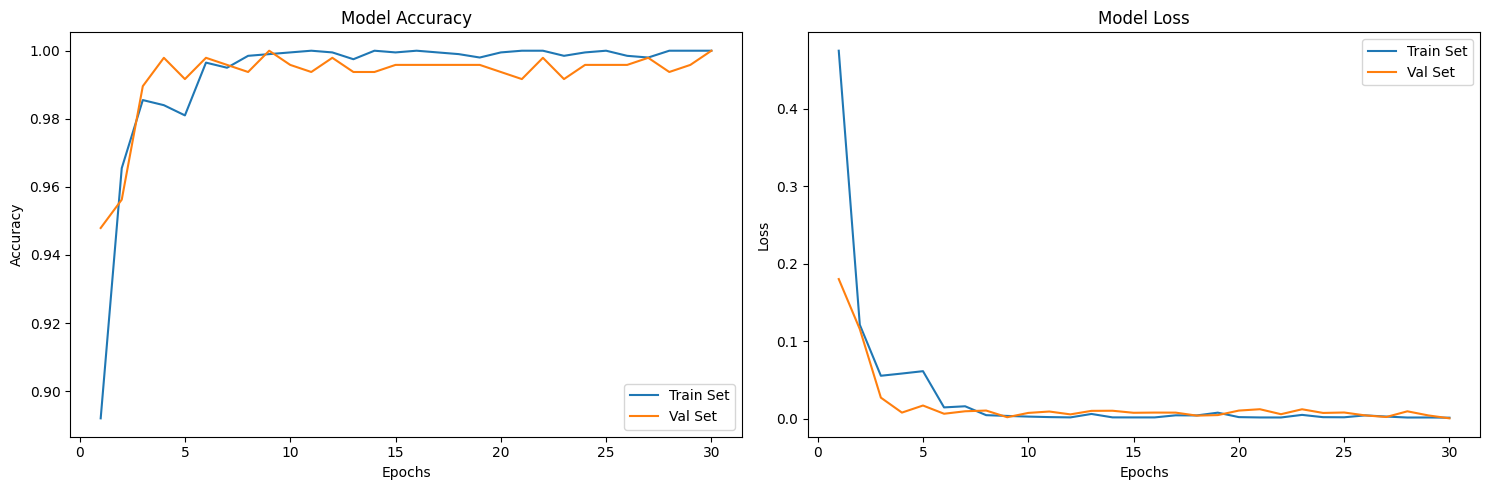

In [37]:
acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']
loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
epochs_range = range(1, len(efficientnet_history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()

In [38]:
import os
print(os.listdir('./'))


['.config', 'TEST_BMD', 'brain_tumor_detection', 'TEST', 'Tumeur_cerveau', 'TEST_BDB_CROP', 'brain-tumor-detection.zip', 'bd-braintumor.zip', 'VAL', 'TRAIN_CROP', 'brain_tumor_dataset', 'brain-mri-images-for-brain-tumor-detection.zip', 'drive', 'kaggle.json', 'VAL_CROP', '.ipynb_checkpoints', 'TEST_BMI', 'TEST_CROP', 'TEST_BMI_CROP', 'TEST_BMD_CROP', 'EfficientNetB2_cropping+equalization.keras', 'logs', 'TRAIN', 'TEST_BDB', 'sample_data']


In [39]:
from tensorflow.keras.models import load_model
model = load_model('/content/EfficientNetB2_cropping+equalization.keras')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 global_max_pooling2d (Glob  (None, 1408)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 1)                 1409      
                                                                 
Total params: 7769978 (29.64 MB)
Trainable params: 7702403 (2

27/27 [==============================] - 10s 297ms/step
Val Accuracy =  0.9952718676122931


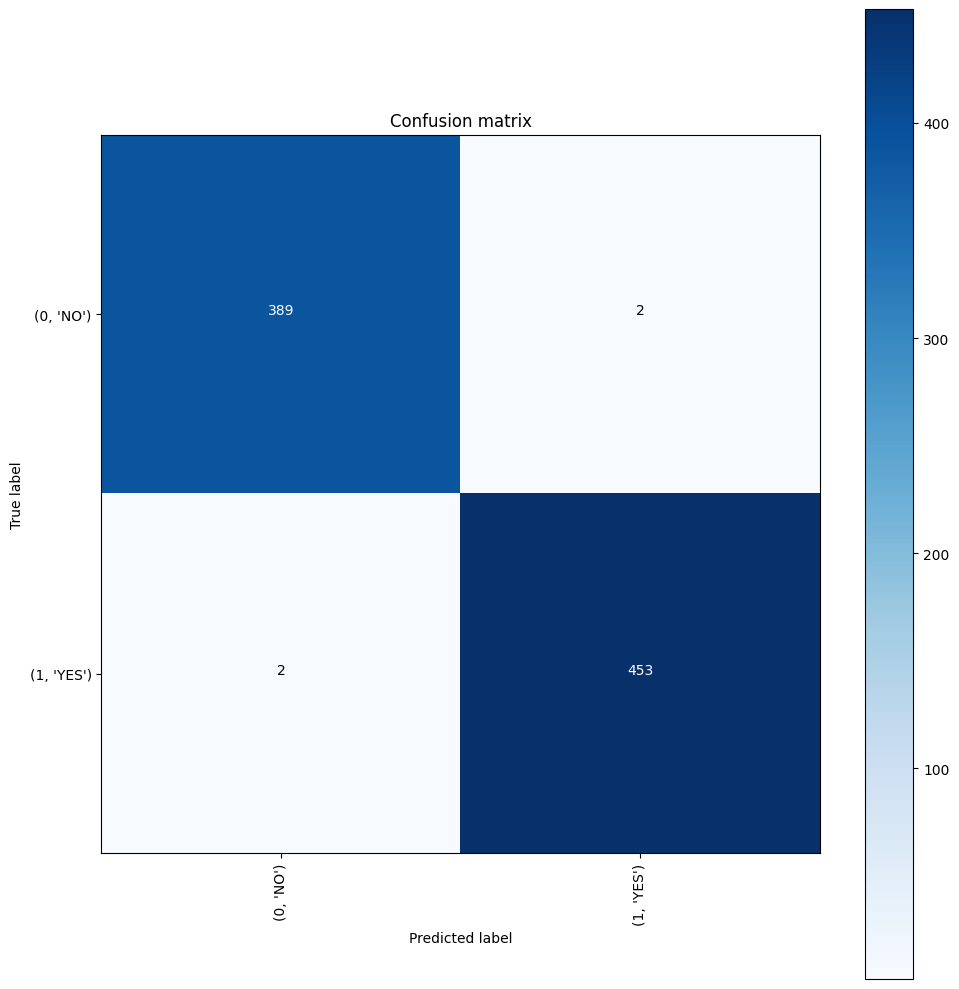

In [40]:
predictions = efficientnet.predict(X_val_crop_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = ' , accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

13/13 [==============================] - 4s 309ms/step
Test Accuracy  0.99


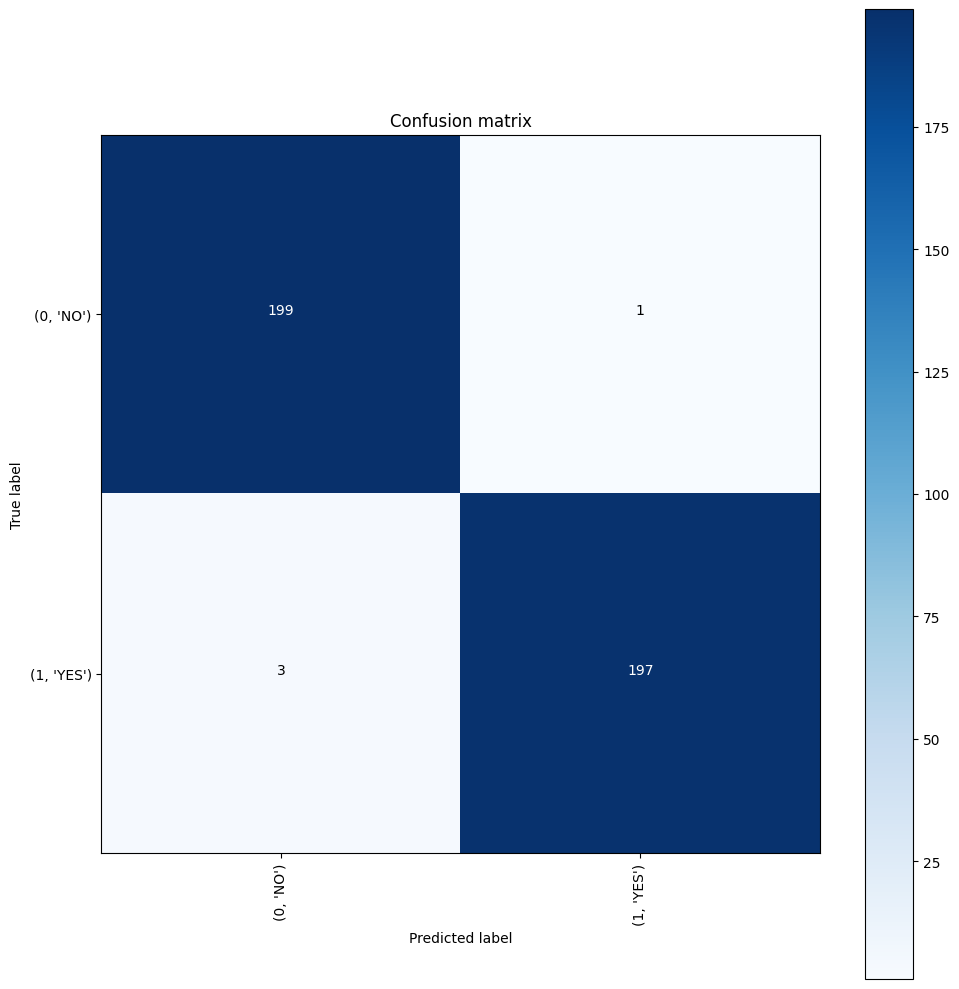

In [41]:
# validate on test set
predictions = efficientnet.predict(X_test_crop_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy ', accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

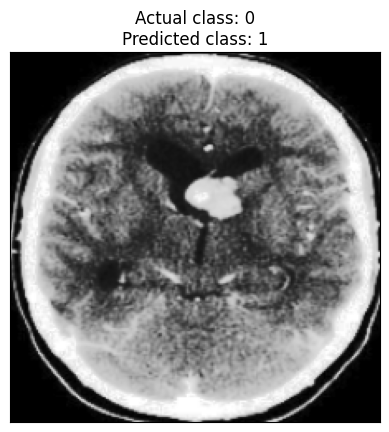

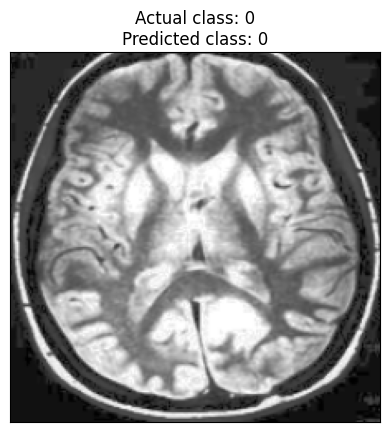

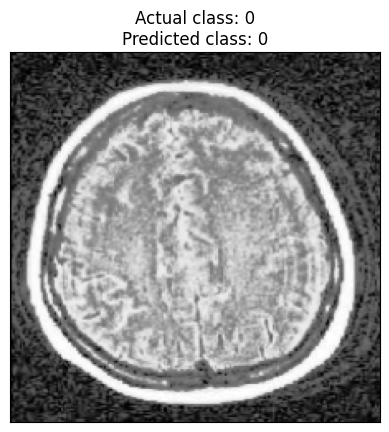

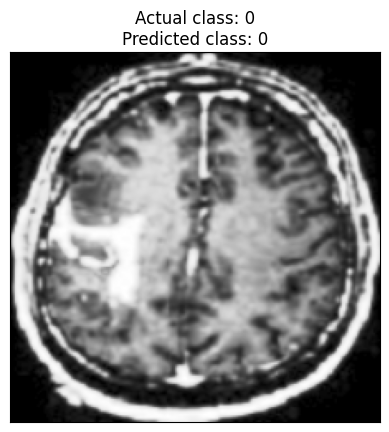

In [42]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
print
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

8/8 [==============================] - 3s 317ms/step
Val Accuracy  0.9881422924901185


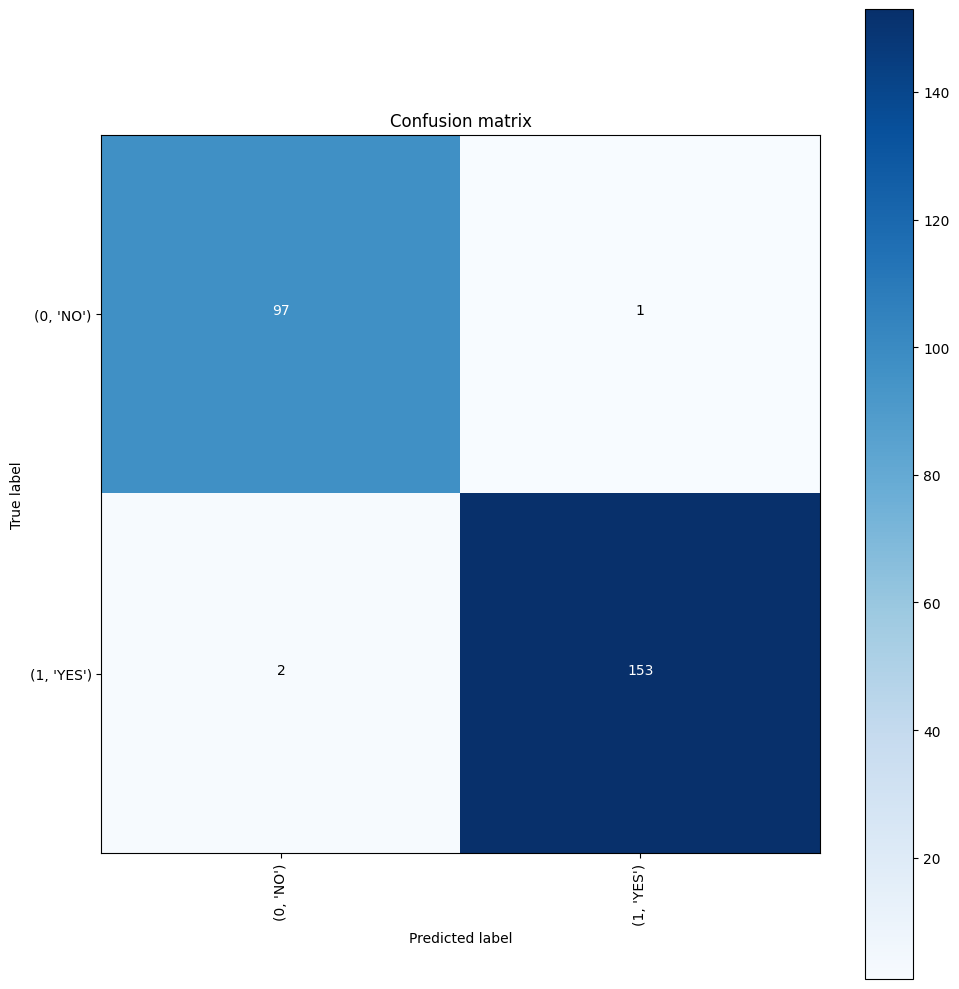

In [43]:
predictions = efficientnet.predict(X_test_bmi_crop_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test_bmi, predictions)
print('Val Accuracy ', accuracy)

confusion_mtx = confusion_matrix(y_test_bmi, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

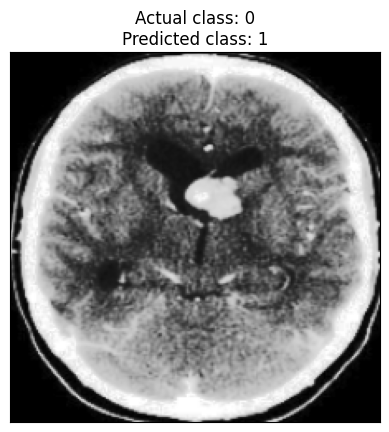

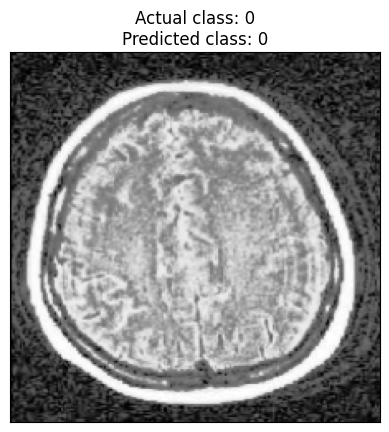

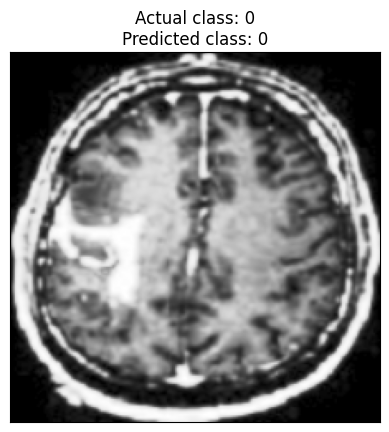

In [44]:
ind_list = np.argwhere((y_test_bmi == predictions) == False)[:, -1]
print
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_bmi_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model,'model.png',show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
print("Length of y_val:", len(y_val))
print("Length of predictions:", len(predictions))

Length of y_val: 846
Length of predictions: 253


In [47]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test_bmi, predictions, target_names=['NO', 'YES'])
print("Classification Report for Test BMI Set:")
print(classification_rep)

Classification Report for Test BMI Set:
              precision    recall  f1-score   support

          NO       0.98      0.99      0.98        98
         YES       0.99      0.99      0.99       155

    accuracy                           0.99       253
   macro avg       0.99      0.99      0.99       253
weighted avg       0.99      0.99      0.99       253



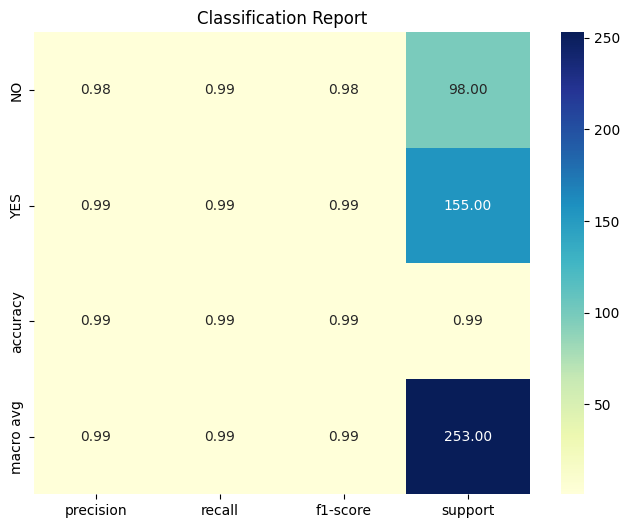

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
classification_rep = classification_report(y_test_bmi, predictions, target_names=['NO', 'YES'], output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()
plt.figure(figsize=(8, 6))
sns.heatmap(classification_df.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classification Report')
plt.show()

Processing /content/brain_tumor_detection
102/102 [==============================] - 34s 310ms/step


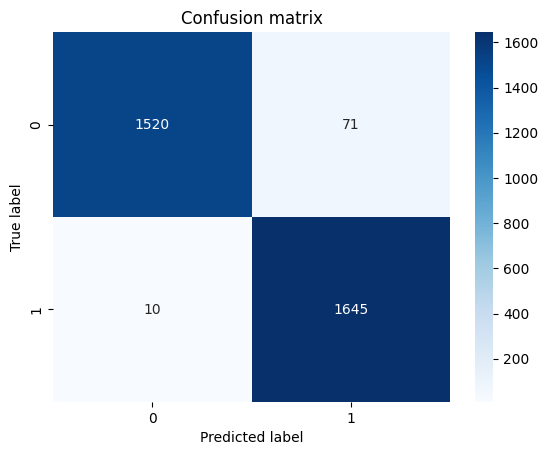

Processing /content/brain_tumor_dataset
8/8 [==============================] - 2s 290ms/step


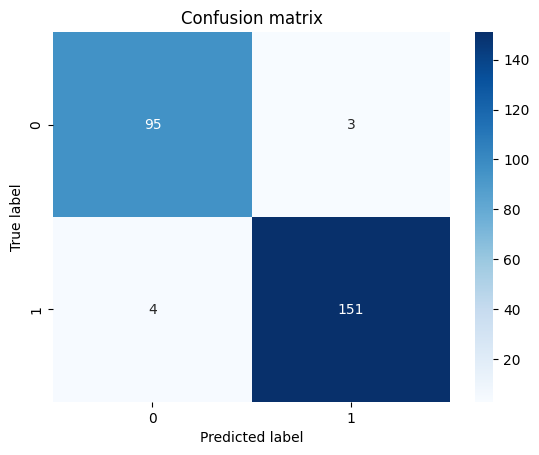

In [50]:
import os
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def load_and_preprocess_images(directory, img_size):
    X = []
    y = []
    labels = {'yes': 1, 'no': 0}
    for label in ['yes', 'no']:
        path = os.path.join(directory, label)
        class_num = labels[label]
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, img_size)
                X.append(new_array)
                y.append(class_num)
            except Exception as e:
                pass
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
model = load_model('/content/EfficientNetB2_cropping+equalization.keras')
directories = [
    '/content/brain_tumor_detection',
    '/content/brain_tumor_dataset',
]
IMG_SIZE = (224, 224)
for directory in directories:
    print(f"Processing {directory}")
    X, y = load_and_preprocess_images(directory, IMG_SIZE)
    X_prep = resize_imgs(X, IMG_SIZE)
    predictions = model.predict(X_prep)
    predictions = [1 if x > 0.5 else 0 for x in predictions]
    cm = confusion_matrix(y, predictions)
    plot_confusion_matrix(cm, ['NO', 'YES'])

Processing /content/Tumeur_cerveau/test
65/65 [==============================] - 23s 319ms/step


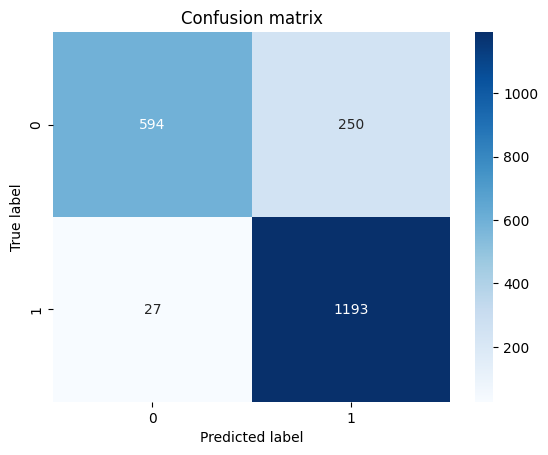

In [52]:
import os
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_and_preprocess_images(directory, img_size):
    X = []
    y = []
    labels = {'1': 1, '2': 0}
    for label in ['1', '2']:
        path = os.path.join(directory, label)
        class_num = labels[label]
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, img_size)
                X.append(new_array)
                y.append(class_num)
            except Exception as e:
                pass
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
model = load_model('/content/EfficientNetB2_cropping+equalization.keras')
directory = '/content/Tumeur_cerveau/test'
IMG_SIZE = (224, 224)
print(f"Processing {directory}")
X, y = load_and_preprocess_images(directory, IMG_SIZE)
X_prep = resize_imgs(X, IMG_SIZE)
predictions = model.predict(X_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]
cm = confusion_matrix(y, predictions)
plot_confusion_matrix(cm, ['NO', 'YES'])